# TUTORIAL: HIGH FREQUENCY METRICS
Author: Jason Helgren

This notebook explains the features generated by the function highFreqMetrics in metrics.py. This function generates four features that describe frequencies in the 200 - 400 Hz range, which is above the frequency range for right whale calls. These features are intended to reduce false positives.

The first step in the highFreqMetrics function is enhance contrast in P, the spectrogram. Contrast enhancement uses the slidingWindowH function. Refer to the Image Preprocessing tutorial for more detail about how this works. An example with one of the whale images is shown below.

First import libraries and define functions.

In [1]:
%matplotlib inline

import aifc
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import mlab, cm
import numpy as np
%matplotlib inline

In [2]:
# Set path to directory with folders train and test
path_data = '/Users/jason/code/msan630/project/whale/data/'

In [3]:
# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

# Read one file as an example
params = {'NFFT':256, 'Fs':2000, 'noverlap':192} 
s = ReadAIFF(path_data + 'train/train6.aiff')
P, freqs, bins = mlab.specgram(s, **params)

In [4]:
freqs[25]

195.3125

In [5]:
# This function is copied from the winning submission code.
def slidingWindowH(P,inner=3,outer=32,maxM=50,norm=True):
    """ Enhance the constrast horizontally (along temporal dimension)

        Cut off extreme values and demean the image
        Utilize numpy convolve to get the mean at a given pixel
        Remove local mean with inner exclusion region

        Args:
            P: 2-d numpy array image
            inner: inner exclusion region 
            outer: length of the window
            maxM: size of the output image in the y-dimension
            norm: boolean to cut off extreme values

        Returns:
            Q: 2-d numpy contrast enhanced vertically
    """
    Q = P.copy()
    m, n = Q.shape
    if norm:
        mval, sval = np.mean(Q[:maxM,:]), np.std(Q[:maxM,:])
        fact_ = 1.5
        Q[Q > mval + fact_*sval] = mval + fact_*sval
        Q[Q < mval - fact_*sval] = mval - fact_*sval
    wInner = np.ones(inner)
    wOuter = np.ones(outer)
    for i in range(maxM):
        Q[i,:] = Q[i,:] - (np.convolve(Q[i,:],wOuter,'same') - np.convolve(Q[i,:],wInner,'same'))/(outer - inner)
    return Q[:maxM,:]

In [6]:
# Spectrogram plotting function
def plot_spectrogram(ax, P):
    plt.imshow(P, origin='lower', extent=[-6,6,-1,1], aspect=4, cmap = cm.get_cmap('bwr'))
    loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    ax.set_xticklabels(np.arange(-0.5,2.5,0.5))
    ax.set_yticklabels(range(0,1001,250))
    ax.set_xlabel('Time (seconds)', fontsize = 12)
    ax.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


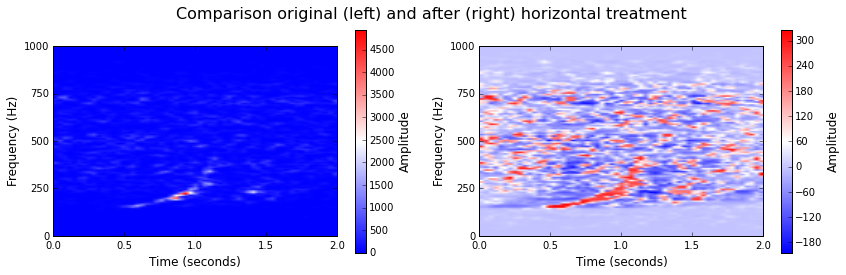

In [7]:
Q = slidingWindowH(P,inner=7,maxM=P.shape[0],norm=True)
fig = plt.figure(figsize = (14,4))
ax1 = plt.subplot(121)
plot_spectrogram(ax1, P)
ax2 = plt.subplot(122)
plot_spectrogram(ax2, Q)
plt.suptitle('Comparison original (left) and after (right) horizontal treatment ', fontsize = 16)
plt.show()

The contrast enhanced imaged used by highFreqMetrics is different from the example shown above in two ways:
- The image is limited to the 50th frequency bin (maxM=50), which corresponds to roughly 400 Hz. 
- The contrast enhanced image is further cropped to eliminate frequencies below about 200 Hz (using array slicing).
- The resulting image includes only frequencies between 200 and 400 Hz, which is outside of the frequency range for right whale calls.

After contrast enhancement and limiting the frequency range, the winning submission calculates four statistics:
1. The standard deviation of the centroids for each frequency bin.
2. The mean of the widths for each frequency bin.
3. The centroid of the sum of the frequency bins.
4. The moment of the sum of the frequency bins.

The code below is commented to show individual steps to calculate these statistics:

In [8]:
# Q is the contrast enhanced and sliced version of the original spectrogram.
m, n = Q.shape
# These empty arrays have length 25, which the number of remaining frequency bins.
cf_ = np.empty(m) 
bw_ = np.empty(m)

In [9]:
# Loop through the 25 frequency bins.
for i in range(m): 
    # Normalize each for each frequency to [0,1]
    mQ = Q[i,:] 
    min_, max_ = mQ.min(), mQ.max()
    mQ = (mQ - min_)/(max_ - min_)
    # Find the location of the centroid and add to the cf_ array.
    cf_[i] = np.sum(mQ*bins)/np.sum(mQ)
    # Find the width and add to the bw_array.
    bw_[i] = np.sqrt(np.sum(mQ*(bins-cf_[i])*(bins-cf_[i]))/np.sum(mQ))

# Slice to get the upper range of of the 200-400 Hz range. For each time bin, sum values from each frequency bin.
# the ,0 gives us a vector of columns (time bin) sums instead of summing everything.
# Slice to remove additional low frequencies from Q. Sum the column (frequencies) for each time bin. 
mQ = np.sum(Q[14:,:],0) 
# Normalize this vector of column sums.
min_, max_ = mQ.min(), mQ.max()
mQ = (mQ - min_)/(max_ - min_) 
# Find the centroid and moment of the normalized array.
cfM_ = np.sum(mQ*bins)/np.sum(mQ)
bwM_ = np.sqrt(np.sum(mQ*(bins - cfM_)*(bins - cfM_))/np.sum(mQ))

print [np.std(cf_), np.mean(bw_), cfM_, bwM_]

[0.03692023396205063, 0.56764800691086159, 0.95463828077603952, 0.59957608755011249]
